In [1]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

# J comparison of gene networks from human interactome, cellmaps, omnipath,

In [2]:
gwps = get_perturb_gt()
omni = get_GT_db('omnipath')
collectri = get_GT_db('collectri')

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:671: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


In [ ]:
# getting U2OS cell map data
import json
import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream('95bc75d5-d1d1-11ee-8a40-005056ae23aa')

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print('Name: ' + net_cx.get_name())
print('Number of nodes: ' + str(len(net_cx.get_nodes())))
print('Number of nodes: ' + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)


Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842
[
  {
    "CXVersion": "2.0",
    "hasFragments": false
  },
  {
    "metaData": [
      {
        "


In [4]:
# extracting PPI data from "computing the human interactome"
humaninter = pd.read_csv('http://prodata.swmed.edu/humanPPI/bulk_download/GoodPairs.txt', sep='\t', skiprows=4)

In [10]:
gwps.var.index = gwps.var.gene_name

In [ ]:
gwps = gwps.extract_links()

,regulators,targets,weight
0,DPM1,DPM1,True
3420,RPL27,DPM1,True
5880,PPIB,DPM1,True
6467,DAG1,DPM1,True
17128,C1orf112,C1orf112,True
...,...,...,...
73162076,MRPL12,TBCE,True
73162135,SNHG8,TBCE,True
73162139,TAF15,TBCE,True
73162183,AL034397.3,TBCE,True


In [ ]:
omni_s = set([s+"_"+t for s,t in omni.iloc[:,:2].values])
collectri_s = set([s+"_"+t for s,t in collectri.iloc[:,:2].values])
gwps_s = set([s+"_"+t for s,t in gwps.iloc[:,:2].values])
humaninter_s = set([s+"_"+t for s,t in humaninter.iloc[:,2:4].values])
cellmap_s = set([s+"_"+t for s,t in cellmap.iloc[:,[2,4]].values])

In [26]:
print("number of edges in gwps: ", len(gwps_s))
print("number of edges in omni: ", len(omni_s))
print("number of edges in collectri: ", len(collectri_s))
print("number of edges in humaninter: ", len(humaninter_s))
print("number of edges in cellmap: ", len(cellmap_s))

number of edges in gwps:  1115036
number of edges in omni:  273556
number of edges in collectri:  63076
number of edges in humaninter:  29237
number of edges in cellmap:  36842


In [50]:
humaninter

{'MSMO1_ARL6IP6',
 'CHRNB1_CHRND',
 'KRT15_KRT28',
 'ZNF655_EVL',
 'SDC3_SDC2',
 'KPNA2_FAM204A',
 'RSL1D1_DDX18',
 'MRPL50_MRPL15',
 'ADAR_TASOR2',
 'TFAP2A_TFAP2C',
 'LOC100653049_KRT32',
 'IGKV3-7_IGLL1',
 'UBE2W_OTUB1',
 'HGS_STAM',
 'SFRP5_C6orf120',
 'BCL2L11_BCL2',
 'OR2AK2_PPP1R14C',
 'IFT81_IFT74',
 'KRT3_KRT25',
 'TCP1_CDC37',
 'EPHA8_EFNA3',
 'LYAR_GAR1',
 'MT-CO1_MT-ND3',
 'CAVIN4_CAVIN3',
 'COMMD2_COMMD3',
 'DCTN1_HSPA12B',
 'NDUFS6_FOXRED1',
 'CLNK_GTSF1L',
 'MT-ND2_NDUFAF1',
 'CIT_DCTN1',
 'KRT19_ERC1',
 'PARD3_BRPF3',
 'IGLV10-54_IGLL1',
 'PTPN6_C8orf33',
 'SIRT6_ABCF2',
 'SEC61G_SEC61B',
 'FLT4_KDR',
 'TRAPPC6B_TRAPPC1',
 'APOBEC1_KRTAP6-2',
 'PTPRZ1_CYP3A7',
 'MRPL21_MRPL20',
 'NXT2_NXF1',
 'NFE2L2_BRPF3',
 'GSTA2_GSTP1',
 'FIP1L1_SIRT6',
 'NKX6-1_FOXA2',
 'S100PBP_PCED1A',
 'ASXL2_BAP1',
 'TUBA3E_TUBB1',
 'CLEC4D_TIMD4',
 'NKAP_FAM50B',
 'IGLV11-55_IGLL1',
 'MIER1_HDAC2',
 'RFXANK_CLK3',
 'ARHGEF10_ARHGEF10L',
 'OR51L1_CD300A',
 'IGLL5_IGKV1D-16',
 'KRT36_KRT39',
 'T

In [39]:
cellmap

{'NPM3_SENP5',
 'LRCH1_DOCK7',
 'NPTN_DSTYK',
 'DHX8_USP42',
 'ZSCAN5A_RRP7A',
 'PBXIP1_NDUFA2',
 'CD68_FAM114A2',
 'GALNS_SLC25A16',
 'RIC3_CEP192',
 'TTC23L_EFCAB7',
 'POP7_LAGE3',
 'TMEM88_SLC12A4',
 'PSMB7_PSMD6',
 'TERF1_ACD',
 'FBXW7_FBXO45',
 'SPIN1_TOPORS',
 'HSPA8_IRF2BP2',
 'HMGA1_TRIP12',
 'ARHGEF35_CCZ1B',
 'TNFRSF6B_ANKRD50',
 'DCAF8_PIP5K1A',
 'COPS3_DDB2',
 'EPB41L5_PRCP',
 'IFT81_IFT74',
 'HSP90AB1_DUSP14',
 'YWHAB_KCTD3',
 'S1PR3_ZDHHC5',
 'CHRNB1_BNIP1',
 'COMMD2_COMMD3',
 'FTL_SKA1',
 'CD27_DTYMK',
 'SIRT6_PML',
 'MUCL1_PDIA5',
 'APLNR_ADGRG1',
 'FAM219A_MRE11',
 'IRF2BP1_RAB34',
 'HMGCL_PNPT1',
 'MFGE8_ENO3',
 'PYM1_ZC3H8',
 'PTH2R_OSMR',
 'TNFSF8_HAUS5',
 'AURKB_TBC1D9B',
 'CREB3_SOAT1',
 'TAX1BP3_AMER1',
 'CRCP_NUDT3',
 'RAB11B_NCKIPSD',
 'PEX7_RAB2B',
 'EGFL8_MPO',
 'RACK1_N4BP2',
 'EAF1_PIP5K1C',
 'SNRNP70_GEMIN5',
 'CCKBR_PIGO',
 'RAD23A_MPG',
 'SLC22A16_TMBIM6',
 'ZNRD2_MGA',
 'FBXW7_HAL',
 'C9orf40_TRAPPC10',
 'WASHC3_BLOC1S4',
 'XXYLT1_PDCD2L',
 'KBTBD7_EBI3

In [42]:
gwps

{'RPL7A_ZGPAT',
 'SLC35A3_DDX6',
 'EGFL7_SRP19',
 'ADI1_CHORDC1',
 'PIK3CB_DNMT1',
 'PRPSAP2_LTV1',
 'ZNF672_MBTPS2',
 'CCNA2_DENR',
 'TALDO1_ILF3',
 'GIHCG_PTGR2',
 'PTMS_DLD',
 'ZNF117_GTF2H1',
 'LCP1_MRPS17',
 'FAM136A_FBXW11',
 'MRPL33_MRPL10',
 'HAUS2_DPY19L4',
 'ZNF431_BRIX1',
 'WDR18_EIF3H',
 'MLLT10_DDX10',
 'PPIE_EIF3J',
 'BRD4_NHP2',
 'RCN2_POLR2M',
 'ACAT2_SCAP',
 'S100A13_POLR1B',
 'WDFY2_MED28',
 'HSPA5_EIF3A',
 'CTNNBIP1_RNF40',
 'RPP21_ESF1',
 'MRPL12_MRPS34',
 'PKP4_CSTF3',
 'UBC_SDAD1',
 'GATA2_POLR2G',
 'NACA_GPN3',
 'SERPINF1_TMEM115',
 'YBX1_MOV10',
 'SRRT_FUNDC2',
 'OAZ1_RMI1',
 'RPP25_MED30',
 'HEMGN_RPS10',
 'ELAC2_MED28',
 'PSMA2_RPL19',
 'CBX5_AARS',
 'ZNF511_TARS',
 'TXNRD1_MED28',
 'RPL34_HSPA5',
 'SOD1_INO80',
 'CENPJ_KDM1A',
 'SH3BGRL3_ABCB7',
 'VDAC3_RPAP2',
 'MT-CO2_NARS',
 'GOLPH3_TAF1',
 'NKTR_RNF31',
 'SRP68_EIF3A',
 'PLOD2_GPS2',
 'PDLIM2_KANSL2',
 'DDX1_CCNQ',
 'XPC_ING5',
 'C1orf43_MED21',
 'UQCRB_EEF1G',
 'MRPL2_GPN3',
 'RPSA_UTP18',
 'MED28_SUPT6H

In [46]:
humaninter

{'MSMO1_ARL6IP6',
 'CHRNB1_CHRND',
 'KRT15_KRT28',
 'ZNF655_EVL',
 'SDC3_SDC2',
 'KPNA2_FAM204A',
 'RSL1D1_DDX18',
 'MRPL50_MRPL15',
 'ADAR_TASOR2',
 'TFAP2A_TFAP2C',
 'LOC100653049_KRT32',
 'IGKV3-7_IGLL1',
 'UBE2W_OTUB1',
 'HGS_STAM',
 'SFRP5_C6orf120',
 'BCL2L11_BCL2',
 'OR2AK2_PPP1R14C',
 'IFT81_IFT74',
 'KRT3_KRT25',
 'TCP1_CDC37',
 'EPHA8_EFNA3',
 'LYAR_GAR1',
 'MT-CO1_MT-ND3',
 'CAVIN4_CAVIN3',
 'COMMD2_COMMD3',
 'DCTN1_HSPA12B',
 'NDUFS6_FOXRED1',
 'CLNK_GTSF1L',
 'MT-ND2_NDUFAF1',
 'CIT_DCTN1',
 'KRT19_ERC1',
 'PARD3_BRPF3',
 'IGLV10-54_IGLL1',
 'PTPN6_C8orf33',
 'SIRT6_ABCF2',
 'SEC61G_SEC61B',
 'FLT4_KDR',
 'TRAPPC6B_TRAPPC1',
 'APOBEC1_KRTAP6-2',
 'PTPRZ1_CYP3A7',
 'MRPL21_MRPL20',
 'NXT2_NXF1',
 'NFE2L2_BRPF3',
 'GSTA2_GSTP1',
 'FIP1L1_SIRT6',
 'NKX6-1_FOXA2',
 'S100PBP_PCED1A',
 'ASXL2_BAP1',
 'TUBA3E_TUBB1',
 'CLEC4D_TIMD4',
 'NKAP_FAM50B',
 'IGLV11-55_IGLL1',
 'MIER1_HDAC2',
 'RFXANK_CLK3',
 'ARHGEF10_ARHGEF10L',
 'OR51L1_CD300A',
 'IGLL5_IGKV1D-16',
 'KRT36_KRT39',
 'T

<Axes: >

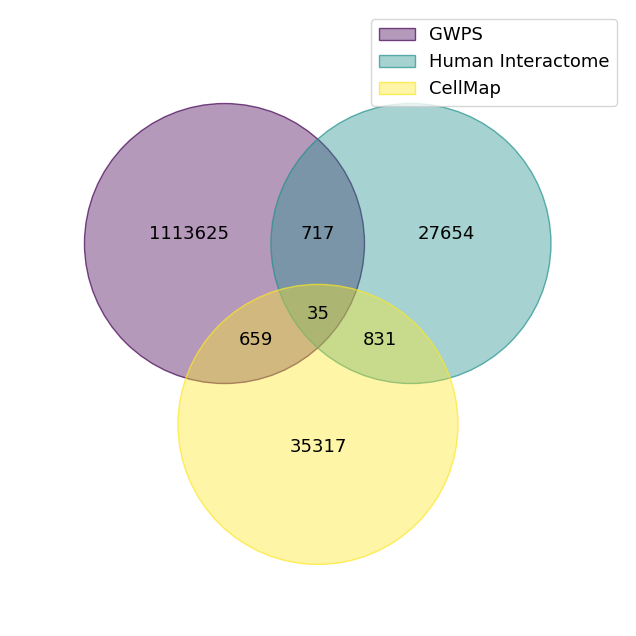

In [56]:
from venn import venn

# Create a dictionary of sets
sets = {
    #'OmniPath': omni,
    #'CollecTRI': collectri,
    'GWPS': gwps,
    'Human Interactome': humaninter,
    'CellMap': cellmap
}

venn(sets)

<Axes: >

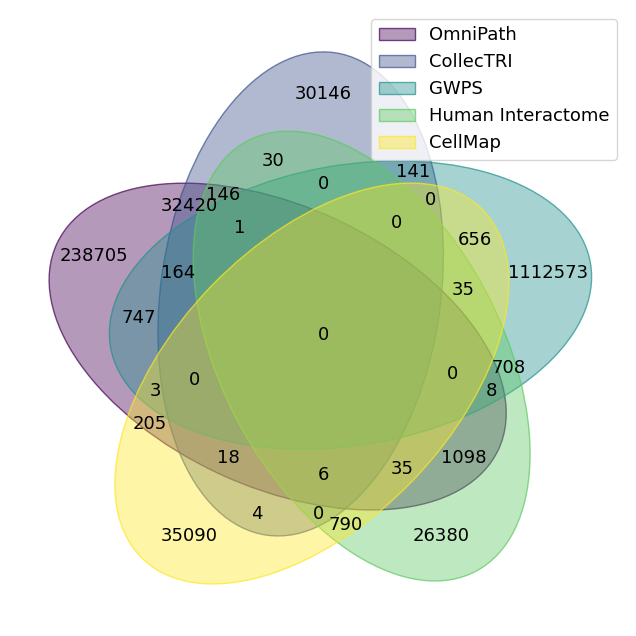

In [57]:
sets = {
    'OmniPath': omni,
    'CollecTRI': collectri,
    'GWPS': gwps,
    'Human Interactome': humaninter,
    'CellMap': cellmap
}

venn(sets)

<Axes: >

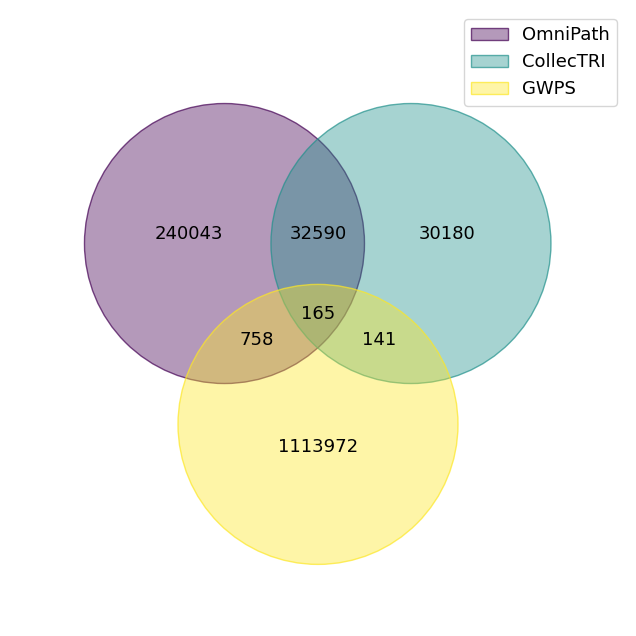

In [58]:
sets = {
    'OmniPath': omni,
    'CollecTRI': collectri,
    'GWPS': gwps,
    #'Human Interactome': humaninter,
    #'CellMap': cellmap
}

venn(sets)

# J look at nodes that stay the same across similar cells, different cell types (HOW??), species (human / mouse / chimp) (select a module of ~15 genes